<center>
<img src="https://drive.google.com/uc?id=1f1gGVI-rxcHjA90WEGNvvtSXF1pAxQwg" alt="Fasilkom UI" width="300"/>

CSGE603130 • Kecerdasan Artifisial dan Sains Data Dasar

Semester Ganjil 2022/2023

Fakultas Ilmu Komputer, Universitas Indonesia

##**TUGAS AKHIR**

## Final Project KASDD

---



DAEGU APARTMENTS

Nama Kelompok : Hello Panda
Kelas : KASDD D

1.   Caryn Hanuga - 2006596541
2.   Graciella Regina Indria Suwono - 2006463
3.   Helga Syahda Elmira - 2006463686
4.   Metta Permatasari - 2006463761

In [ ]:
#Import EDA (exploratory data analysis) and plotting library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp

%matplotlib inline 
#Import models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn import metrics, svm
from sklearn import preprocessing
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

**Membaca dataset Daegu Apartments**

In [ ]:
# Import dataset daegu apartments
daegu_df = pd.read_csv("06_DaeguApartments.csv")

# Eksplorasi Sederhana

## Fasilitas apa saja yang paling berpengaruh terhadap harga apartemen?

In [ ]:
# Melihat deskripsi statistik dari kelompok fitur kategorikal (untuk preprocess)
display(daegu_df.describe(include=object))

ValueError: ignored

In [ ]:
# Melakukan one-hot encoding data kategorikal dikarenakan fasilitas apartemen memiliki bentuk kategorikal
daegu_df_old = daegu_df
daegu_df= pd.get_dummies(daegu_df, drop_first=True)
daegu_df.head()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,...,TimeToSubway_15min~20min,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,2007,8,814,3,111,184,3,3,...,0,0,0,0,0,0,1,0,0,0
1,51327,1985,2007,8,587,8,80,76,1,2,...,0,1,0,0,0,1,0,0,0,0
2,48672,1985,2007,8,587,6,80,76,1,2,...,0,1,0,0,0,1,0,0,0,0
3,380530,2006,2007,8,2056,8,249,536,6,5,...,0,0,0,0,0,0,0,0,1,0
4,221238,1993,2007,8,1761,3,523,536,8,8,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
data = daegu_df
data = data.drop(['YearBuilt', 'YrSold','MonthSold','N_APT','N_manager','FamilyFriendly','Floor', 'SubwayStation_Banwoldang', 'SubwayStation_Chil-sung-market', 'SubwayStation_Daegu','SubwayStation_Kyungbuk_uni_hospital', 'SubwayStation_Myung-duk','SubwayStation_Sin-nam'], axis=1)

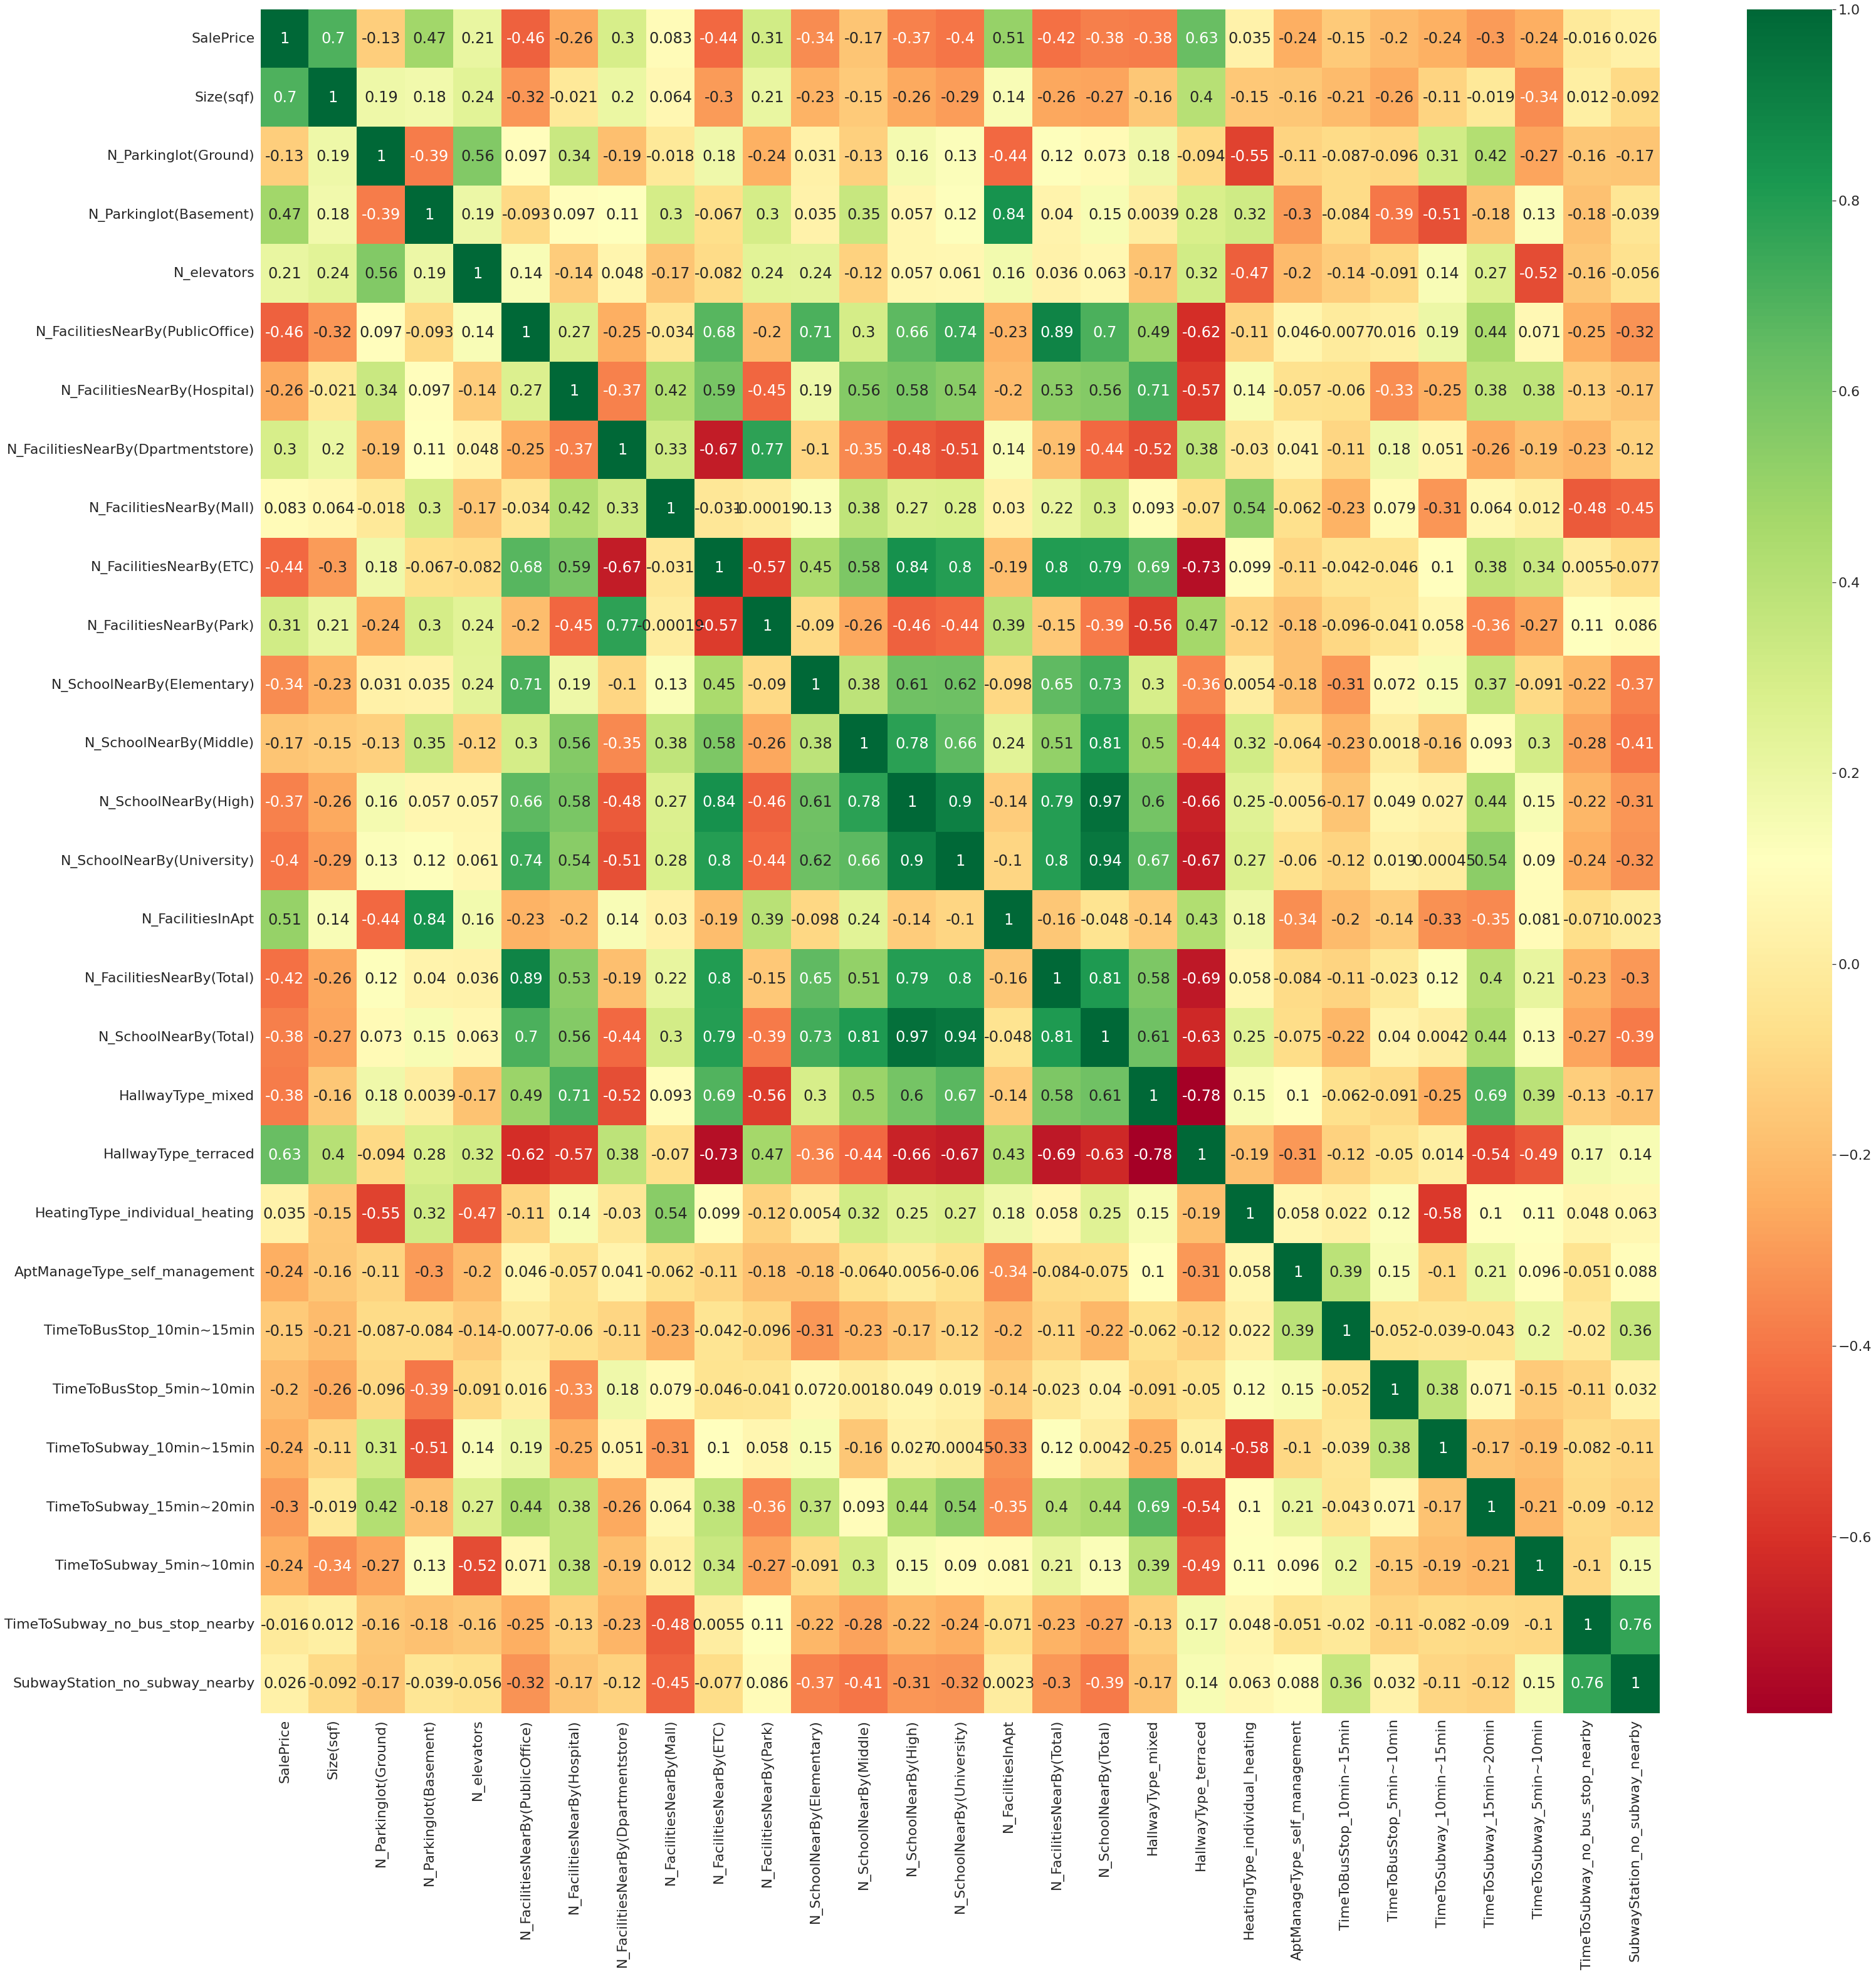

In [ ]:
corrmat = data.corr()
top_corr_features = corrmat.index
sns.set(font_scale=2)
plt.figure(figsize=(50,50))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Jika dilihat dari hasil heatmap, beberapa variabel yang merupakan fasilitas dan paling berpengaruh terhadap harga apartemen dengan asumsi nilai korelasi >=0.5 atau -0.5 antara lain :
1. **Size dari apartemen** dengan nilai korelasi = 0.70
2. **Hallway dengan tipe terrace** dengan nilai korelasi 0.63
3. N_facilitiesInApt (**jumlah fasilitas pada apartemen**) dengan nilai korelasi 0.51

## Apakah terdapat perbedaan harga yang signifikan antara apartemen yang dibangun sebelum dan setelah tahun 2000?

Membagi data menjadi data apartemen yang dibangun pada tahun 2000 kebawah dan setelah tahun 2000

In [ ]:
#Apartemen yang dibangun pada tahun <=2000
daegu_under2000 = daegu_df.loc[daegu_df['YearBuilt'] <= 2000]

daegu_under2000_harga = daegu_under2000['SalePrice']
len(daegu_under2000_harga)

1761

In [ ]:
#Apartemen yang dibangun pada tahun >2000
daegu_above2000 = daegu_df.loc[daegu_df['YearBuilt'] > 2000]
daegu_above2000_harga = daegu_above2000['SalePrice']
len(daegu_above2000_harga)

4130

Menghitung jumlah outlier pada data harga (SalePrice) apartemen dibawah tahun 2000

In [ ]:
# Melihat jumlah kemungkinan adanya outliers pada data menggunakan IQR

# Menghitung quartil 1 dan 3.
Q1_u = daegu_under2000_harga.quantile(0.25)
Q3_u = daegu_under2000_harga.quantile(0.75)

Q1_a = daegu_above2000_harga.quantile(0.25)
Q3_a = daegu_above2000_harga.quantile(0.75)

# Menghitung RUB dan RLB.
IQR_u = Q3_u - Q1_u
lower_limit_u = Q1_u - 1.5*IQR_u
upper_limit_u = Q3_u + 1.5*IQR_u

IQR_a = Q3_a - Q1_a
lower_limit_a = Q1_a - 1.5*IQR_a
upper_limit_a = Q3_a + 1.5*IQR_a

# Menampilkan banyaknya outlier pada atribut.
outliers_u = (daegu_under2000_harga < lower_limit_u) | (daegu_under2000_harga >= upper_limit_u)
print ("Banyaknya jumlah outlier pada atribut under 2000:")
print(outliers_u.sum())

outliers_a = (daegu_above2000_harga < lower_limit_a) | (daegu_above2000_harga >= upper_limit_a)
print ("Banyaknya jumlah outlier pada atribut above 2000:")
print(outliers_a.sum())

Banyaknya jumlah outlier pada atribut under 2000:
40
Banyaknya jumlah outlier pada atribut above 2000:
10


Karena outlier pada data hanya (40/1757) = 2,27%, dan (10/4130) = 0.24% maka outlier tidak perlu ditangani (sangat kecil).

In [ ]:
# Mencari data rata-rata dari harga apartemen dibawah tahun 2000
mean_price_u2000 = daegu_under2000_harga.mean()
mean_price_u2000

141197.86598523566

In [ ]:
# Mencari data rata-rata dari harga apartemen diatas tahun 2000
mean_price_a2000 = daegu_above2000_harga.mean()
mean_price_a2000

255338.12566585955

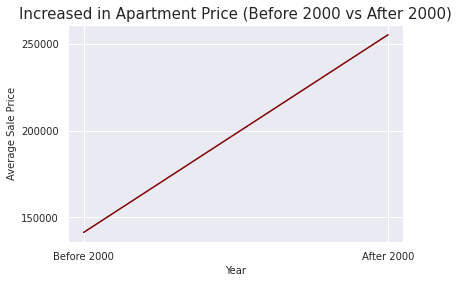

In [ ]:

year = ['Before 2000', 'After 2000']
salePrice = [mean_price_u2000,mean_price_a2000 ]
plt.plot(year, salePrice, color ='maroon')
plt.title('Increased in Apartment Price (Before 2000 vs After 2000)', fontsize=15)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Average Sale Price', fontsize=10)
plt.yticks(size=10)
plt.xticks(size=10)
plt.show()

Menghitung signifikansi harga apartemen

In [ ]:
# Perbedaan harga
diff_price = mean_price_a2000 - mean_price_u2000
diff_price

#Kenaikkan harga dalam persen
percentage_price = (diff_price/mean_price_u2000)*100
print("Berdasarkan perhitungan yang dilakukan,\n kami melihat bahwa terdapat perbedaan harga yang signifikan\n antara apartemen yang dibangun sebelum dan setelah tahun 2000\n yakni sebanyak "+str(percentage_price)+"%.")

Berdasarkan perhitungan yang dilakukan,
 kami melihat bahwa terdapat perbedaan harga yang signifikan
 antara apartemen yang dibangun sebelum dan setelah tahun 2000
 yakni sebanyak 80.83709968574097%.


## Adakah waktu tertentu di mana penjualan apartemen lebih tinggi daripada biasanya?

Waktu yang dipahami disini adalah waktu dengan penjualan unit apartemen tertinggi.

In [ ]:
unitsYear = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
max =0
n =0
unitsSold = []

for i in unitsYear:
  x =  daegu_df.loc[daegu_df['YrSold'] == i]
  unitSold = len(x)
  unitsSold.append(unitSold)
  if (unitSold>max):
    max=unitSold
    maxYear= unitsYear[n]
  n = n + 1  

# print(max)
print("unit apartemen terjual paling banyak di tahun " + str(maxYear) + " dengan jumlah " + str(max))

unit apartemen terjual paling banyak di tahun 2016 dengan jumlah 751


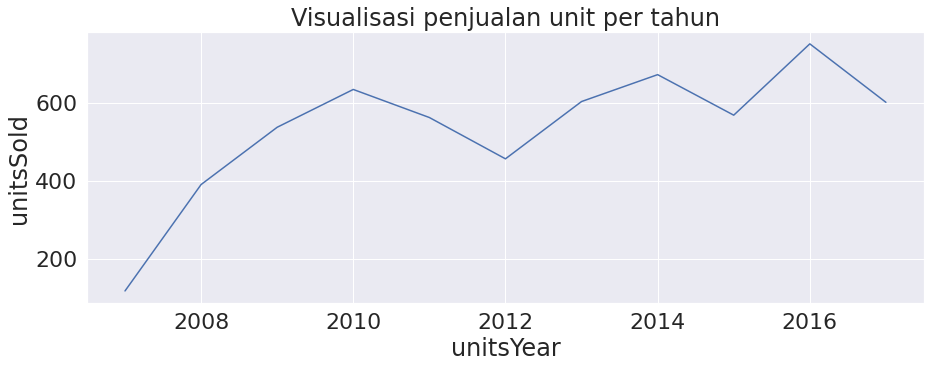

In [ ]:
# Visualisasi penjualan unit per tahun
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(unitsYear, unitsSold)
plt.xlabel('unitsYear')
plt.ylabel('unitsSold')
plt.title('Visualisasi penjualan unit per tahun')
plt.show()

In [ ]:
unitsMonth = [1,2,3,4,5,6,7,8,9,10,11,12]
max =0
n =0
unitsSold = []

for i in unitsMonth:
  x =  daegu_df.loc[daegu_df['MonthSold'] == i]
  unitSold = len(x)
  unitsSold.append(unitSold)
  if (unitSold>max):
    max=unitSold
    maxMonth= unitsMonth[n]
  n = n + 1  

# print(max)
print("unit apartemen terjual paling banyak di bulan " + str(maxMonth) + " dengan jumlah " + str(max))

unit apartemen terjual paling banyak di bulan 1 dengan jumlah 623


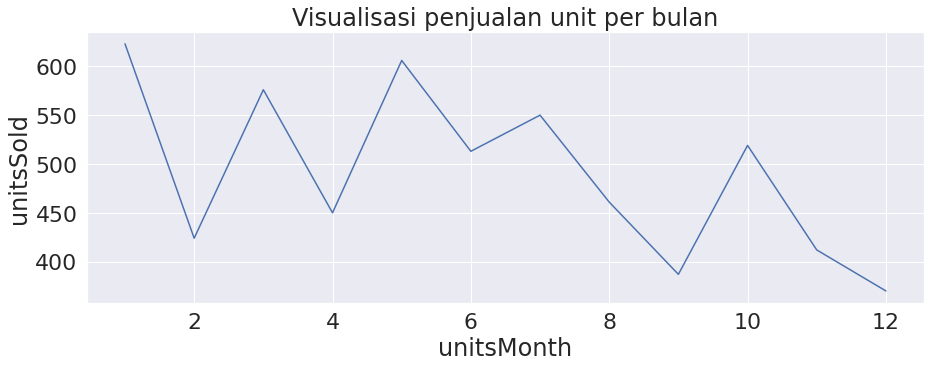

In [ ]:
# Visualisasi penjualan unit per bulan
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(unitsMonth, unitsSold)
plt.xlabel('unitsMonth')
plt.ylabel('unitsSold')
plt.title('Visualisasi penjualan unit per bulan')
plt.show()

In [ ]:
# Cek perbulan pertahun

unitsYear = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
unitsMonth = [1,2,3,4,5,6,7,8,9,10,11,12]
# max =0
# n =0
# m = 0
# unitsSold = []

# for i in unitsYear:
#   for j in unitsMonth:
#     x =  daegu_df.loc[daegu_df['YrSold'] == i]
#     y = x.loc[daegu_df['MonthSold']==j]
#     unitSold = len(y)
#     Year= unitsYear[n]
#     Month=unitsMonth[m]
#     print("unit apartemen terjual di tahun " + str(Year) + " bulan "+str(Month)+" adalah " + str(unitSold))
#     if (unitSold>max):
#       max=unitSold
#       maxYear= unitsYear[n]
#       maxMonth=unitsMonth[m]
#     m = m +1
#   n = n + 1  

# # print(max)
# print("unit apartemen terjual paling banyak di tahun " + str(maxYear) + " bulan "+str(maxMonth)+" dengan jumlah " + str(max))
totalmonth = [0,0,0,0,0,0,0,0,0,0,0,0]
for i in unitsYear:
  x =  daegu_df.loc[daegu_df['YrSold'] == i]
  month = [0,0,0,0,0,0,0,0,0,0,0,0]
  for j in unitsMonth:
    y = len(x.loc[daegu_df['MonthSold']==j])
    month[j-1] = y
    if(j == 12):
      max = month[0]
      index = 0
      for k in range(12):
        if(month[k]>max):
          max = month[k]
          index = k
      totalmonth[index] = totalmonth[index]+1
print(totalmonth)

[2, 0, 1, 0, 2, 0, 2, 0, 1, 1, 2, 0]


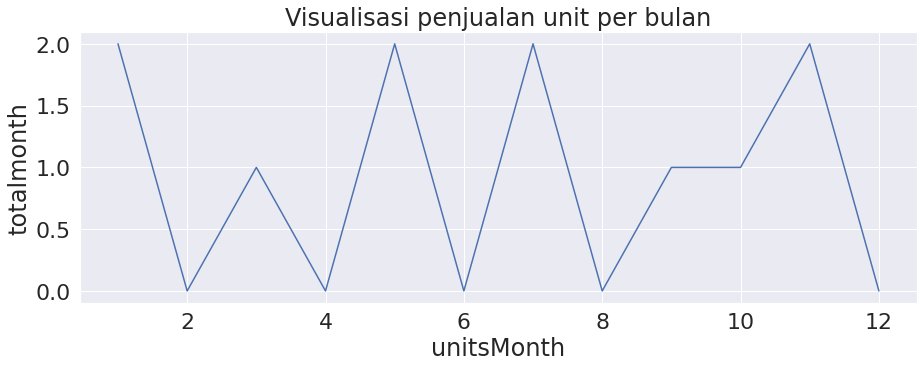

In [ ]:
# Visualisasi penjualan unit per bulan dalam tahun-tahun tersebut
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(unitsMonth, totalmonth)
plt.xlabel('unitsMonth')
plt.ylabel('totalmonth')
plt.title('Visualisasi penjualan unit per bulan')
plt.show()

Jadi dapat dilihat bahwa tren penjualan meningkat pada bulan Januari, Mei, Juli, dan November. Hal ini dapat dilihat dari grafik di atas dimana pada bulan-bulan tersebut penjualan apartemen tertinggi diantara bulan lainnya pada suatu tahun tertentu sebanyak 2x. 

Kalau melihat dari keseluruhan tahun maka tahun dengan penjualan tertinggi ada di tahun 2016 sebanyak 751 unit yang terjual. Jika melihat dari keseluruhan tahun dan bulan, maka bulan Januari memiliki tingkat penjualan tertinggi dengan jumlah 623 unit yang terjual. 

Maka dari itu, jika melihat secara garis besar maka waktu dimana penjualan unit apartemen tertinggi untuk tahun jatuh pada tahun **2016**, untuk bulan jatuh di bulan **Januari**. Namun, secara keseluruhan bulan-bulan yang memiliki penjualan unit tinggi ada pada bulan **Januari, Mei, Juli, dan November**.

## Jelaskan tren perubahan harga penjualan apartemen dari tahun ke tahun!


In [ ]:
minYear = daegu_df['YrSold'].min()
minYear

2007

In [ ]:
maxYear = daegu_df['YrSold'].max()
maxYear

2017

In [ ]:
means = []

In [ ]:
# Memisahkan data pertahun
daegu_2007 = daegu_df.loc[daegu_df['YrSold'] == 2007]
daegu_2008 = daegu_df.loc[daegu_df['YrSold'] == 2008]
daegu_2009 = daegu_df.loc[daegu_df['YrSold'] == 2009]
daegu_2010 = daegu_df.loc[daegu_df['YrSold'] == 2010]
daegu_2011 = daegu_df.loc[daegu_df['YrSold'] == 2011]
daegu_2012 = daegu_df.loc[daegu_df['YrSold'] == 2012]
daegu_2013 = daegu_df.loc[daegu_df['YrSold'] == 2013]
daegu_2014 = daegu_df.loc[daegu_df['YrSold'] == 2014]
daegu_2015 = daegu_df.loc[daegu_df['YrSold'] == 2015]
daegu_2016 = daegu_df.loc[daegu_df['YrSold'] == 2016]
daegu_2017 = daegu_df.loc[daegu_df['YrSold'] == 2017]

In [ ]:
# Memisahkan rata-rata harga jual pertahun
means.append(daegu_2007['SalePrice'].mean())
means.append(daegu_2008['SalePrice'].mean())
means.append(daegu_2009['SalePrice'].mean())
means.append(daegu_2010['SalePrice'].mean())
means.append(daegu_2011['SalePrice'].mean())
means.append(daegu_2012['SalePrice'].mean())
means.append(daegu_2013['SalePrice'].mean())
means.append(daegu_2014['SalePrice'].mean())
means.append(daegu_2015['SalePrice'].mean())
means.append(daegu_2016['SalePrice'].mean())
means.append(daegu_2017['SalePrice'].mean())

In [ ]:
# Membuat list tahun
years = []

In [ ]:
for i in range(2007,2018):
  years.append(i)

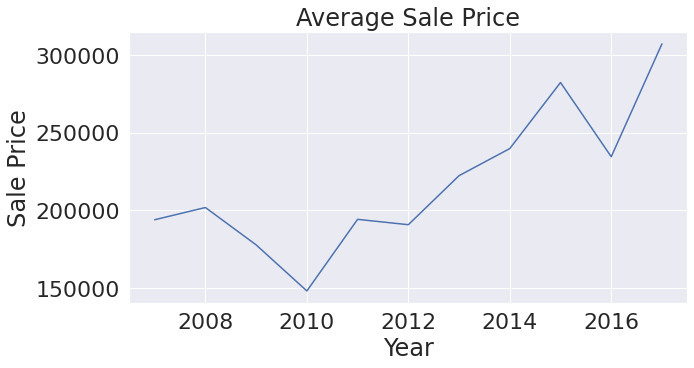

In [ ]:
# Menampilkan visualisasi rata-rata penjualan pertahun
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(years, means)
plt.xlabel('Year')
plt.ylabel('Sale Price')
plt.title('Average Sale Price')
plt.show()

Gambar di atas merupakan gambaran dari tren penjualan keseluruhan tahun Daegu Apartments. Dengan minimal rata-rata harga jual ada pada tahun 2010 dan maksimal rata-rata harga jual di tahun 2017.

## Pengaruh tinggi lantai dengan harga jual (Eksplorasi 1)


In [ ]:
# Menampilkan seluruh tinggi lantai yang tersedia
floor = daegu_df['Floor'].unique().tolist()
floor.sort()

In [ ]:
harga = daegu_df[['SalePrice', 'Floor']]
price = []
for i in floor:
  lantai = harga.loc[harga['Floor']==i]
  hargaa = lantai['SalePrice'].tolist()

  avg_price = sum(hargaa)/len(hargaa)
  price.append(avg_price)

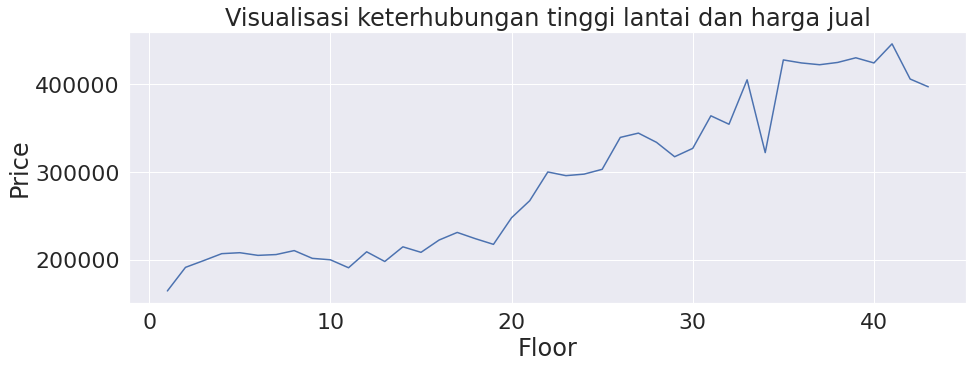

In [ ]:
# Visualisasi keterhubungan tinggi lantai dan harga jual
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(floor, price)
plt.xlabel('Floor')
plt.ylabel('Price')
plt.title('Visualisasi keterhubungan tinggi lantai dan harga jual')
plt.show()

Dari gambar di atas dapat terlihat bahwa semakin tinggi lantai apartment maka, semakin tinggi juga harga jual yang ditawarkan.

## Durasi Penjualan Unit Apartemen di Daegu (Pembangunan s/d Penjualan) (Eksplorasi 2)

In [ ]:
counter = daegu_df.shape[0]
print(counter)

5891


In [ ]:
list = []
for i in range(5575):
  select = daegu_df.iloc[[i]]
  time = int(select['YrSold']-select['YearBuilt'])
  list.append(time)

In [ ]:
print(sum(list)/len(list))
print("rata-rata bangunan yang ada terjual dalam waktu tersebut")

9.690582959641256
rata-rata bangunan yang ada terjual dalam waktu tersebut


In [ ]:
unik = np.unique(list).tolist()
counter = []
for i in unik:
  counter.append(list.count(i))

print(counter)
print(len(counter))

[340, 294, 392, 576, 355, 442, 316, 368, 338, 240, 124, 83, 29, 11, 49, 103, 128, 139, 144, 132, 107, 125, 152, 122, 88, 91, 36, 41, 48, 38, 38, 29, 7, 2, 7, 8, 9, 12, 7, 5]
40


In [ ]:
temp = 0
index = 0
for i in range(40):
  if(counter[i]>temp):
    temp = counter[i]
    index = i

print("Apartemen terbanyak terjual dalam "+str(index)+" tahun")

Apartemen terbanyak terjual dalam 3 tahun


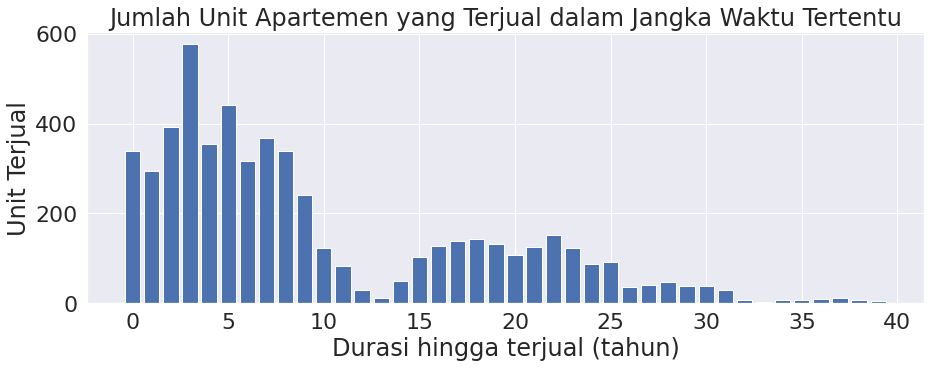

In [ ]:
# Visualisasi jumlah bangunan yang terjual dalam jangka waktu tertentu
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.bar(unik, counter)
plt.xlabel('Durasi hingga terjual (tahun)')
plt.ylabel('Unit Terjual')
plt.title('Jumlah Unit Apartemen yang Terjual dalam Jangka Waktu Tertentu')
plt.show()

Dengan gambar diatas dapat dilihat bahwa unit apartemen paling banyak terjual dalam jangka waktu 3 tahun setelah dibangun. Dapat dilihat juga bahwa banyak apartemen yang terjual dalam jangka waktu dibawah 10 tahun setelah pembangunan. Cenderung sedikit unit apartemen yang terjual apabila telah melewati 10 tahun pertama setelah dibangun. 

# Preprocessing

In [ ]:
original_data = pd.read_csv("06_DaeguApartments.csv")

In [ ]:
daegu_df.head()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),...,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),FamilyFriendly
0,141592,2006,2007,8,814,3,terraced,individual_heating,management_in_trust,111,...,1,0,3,2,2,2,5,6,9,0.0
1,51327,1985,2007,8,587,8,corridor,individual_heating,self_management,80,...,2,1,2,1,1,0,3,12,4,1.0
2,48672,1985,2007,8,587,6,corridor,individual_heating,self_management,80,...,2,1,2,1,1,0,3,12,4,1.0
3,380530,2006,2007,8,2056,8,terraced,individual_heating,management_in_trust,249,...,0,0,2,2,1,2,5,3,7,NaN
4,221238,1993,2007,8,1761,3,mixed,individual_heating,management_in_trust,523,...,5,0,4,3,5,5,4,14,17,0.0


In [ ]:
# Menampilkan ringkasan data setiap kolom
daegu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SalePrice                           5891 non-null   int64  
 1   YearBuilt                           5891 non-null   int64  
 2   YrSold                              5891 non-null   int64  
 3   MonthSold                           5891 non-null   int64  
 4   Size(sqf)                           5891 non-null   int64  
 5   Floor                               5891 non-null   int64  
 6   HallwayType                         5891 non-null   object 
 7   HeatingType                         5891 non-null   object 
 8   AptManageType                       5891 non-null   object 
 9   N_Parkinglot(Ground)                5891 non-null   int64  
 10  N_Parkinglot(Basement)              5891 non-null   int64  
 11  TimeToBusStop                       5891 no

In [ ]:
# Melihat deskripsi statistik dari kelompok fitur numerik
daegu_df.describe()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,...,N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),FamilyFriendly
count,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,...,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5891.000000,5739.000000
mean,221218.112545,2002.967408,2012.691563,6.160244,955.569173,12.026311,195.883551,570.761670,5.613648,6.310304,...,1.941266,0.654218,3.022407,2.417756,2.659311,2.764726,5.809540,9.870820,10.864200,0.231051
std,106384.186446,8.811782,2.905488,3.387752,382.464050,7.548743,218.597210,408.621075,2.811831,3.174088,...,2.201392,0.658320,0.954575,1.037898,1.556041,1.489289,2.330804,3.450319,4.438513,0.421542
min,32743.000000,1978.000000,2007.000000,1.000000,135.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,144247.000000,1993.000000,2010.000000,3.000000,644.000000,6.000000,11.000000,184.000000,3.000000,5.000000,...,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,4.000000,8.000000,7.000000,0.000000
50%,207964.000000,2006.000000,2013.000000,6.000000,910.000000,11.000000,100.000000,536.000000,7.000000,6.000000,...,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,5.000000,9.000000,10.000000,0.000000
75%,291150.000000,2008.000000,2015.000000,9.000000,1149.000000,17.000000,249.000000,798.000000,8.000000,8.000000,...,5.000000,1.000000,4.000000,3.000000,4.000000,4.000000,7.000000,13.000000,15.000000,0.000000
max,585840.000000,2015.000000,2017.000000,12.000000,2337.000000,43.000000,713.000000,1321.000000,13.000000,14.000000,...,5.000000,2.000000,6.000000,4.000000,5.000000,5.000000,10.000000,16.000000,17.000000,1.000000


**Penanganan Missing Values**

In [ ]:
# Melihat jumlah missing values

def cek_missing_values(df):
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = col_na / len(df)
    
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data[missing_data['Total'] > 0]
    
cek_missing_values(daegu_df)

,Total,Percent
FamilyFriendly,152,0.025802


Terdapat missing values pada kolom FamilyFriendly, sebesar 2.58%. Untuk mengatasi ini, nilai null diganti dengan nilai modus karena atribut FamilyFriendly memiliki value dengan tipe data binary (0,1).

In [ ]:
# Menangani missing values dengan median
daegu_df['FamilyFriendly'] = daegu_df['FamilyFriendly'].fillna(daegu_df['FamilyFriendly'].mode()[0])

cek_missing_values(daegu_df)

,Total,Percent


**Penanganan Duplikasi Data**

In [ ]:
# Melihat jumlah duplikasi data
print('Jumlah duplikasi pada data adalah', daegu_df.duplicated(keep=False).sum())

Jumlah duplikasi pada data adalah 486


In [ ]:
daegu_df = daegu_df.drop_duplicates(inplace=False, keep='first', ignore_index=False)
print('Jumlah duplikasi pada data setelah dibersihkan adalah', daegu_df.duplicated(keep=False).sum())

Jumlah duplikasi pada data setelah dibersihkan adalah 0


**Penanganan Outliers**

In [ ]:
# Melihat jumlah kemungkinan adanya outliers pada data menggunakan IQR

# Menghitung quartil 1 dan 3.
Q1 = daegu_df.quantile(0.25)
Q3 = daegu_df.quantile(0.75)

# Menghitung RUB dan RLB.
IQR = Q3 - Q1
lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

# Menampilkan banyaknya outlier pada atribut.
outliers = (daegu_df < lower_limit) | (daegu_df > upper_limit)
print ("Outlier pada tiap atribut:")
print(outliers.sum())

Outlier pada tiap atribut:
AptManageType                            0
FamilyFriendly                        1224
Floor                                   60
HallwayType                              0
HeatingType                              0
MonthSold                                0
N_APT                                    0
N_FacilitiesInApt                        0
N_FacilitiesNearBy(Dpartmentstore)       0
N_FacilitiesNearBy(ETC)                  0
N_FacilitiesNearBy(Hospital)             0
N_FacilitiesNearBy(Mall)               934
N_FacilitiesNearBy(Park)                 0
N_FacilitiesNearBy(PublicOffice)         0
N_FacilitiesNearBy(Total)               64
N_Parkinglot(Basement)                   0
N_Parkinglot(Ground)                   298
N_SchoolNearBy(Elementary)               0
N_SchoolNearBy(High)                     0
N_SchoolNearBy(Middle)                 234
N_SchoolNearBy(Total)                    0
N_SchoolNearBy(University)               0
N_elevators                

<ipython-input-89-7cd19588959b>:13: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = (daegu_df < lower_limit) | (daegu_df > upper_limit)


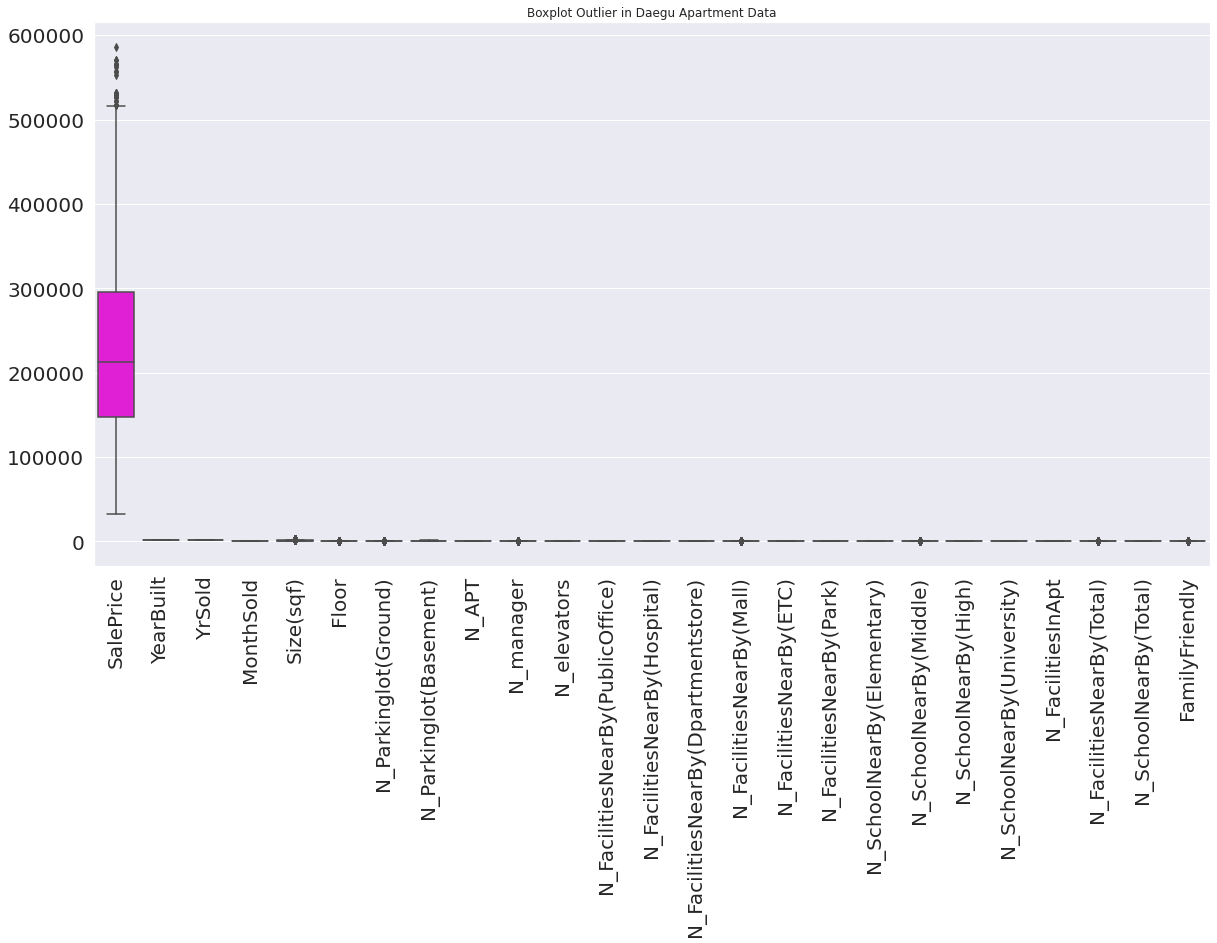

In [ ]:
plt.figure(figsize=(20,10))
plt.xticks(size=20, rotation=90)
plt.yticks(size=20)
sns.set(style="whitegrid")
sns.boxplot(data=daegu_df, 
            palette="gist_rainbow_r")

plt.title("Boxplot Outlier in Daegu Apartment Data")
plt.show()

**Encoding Data Kategorikal**
Karena terdapat kolom yang berjenis kategorikal, maka perlu dilakukan encoding agar menjadi data numerik. Metode encoding yang dilakukan adalah one-hot encoding.

In [ ]:
# Melakukan one-hot encoding data kategorikal
daegu_df_old = daegu_df
daegu_df= pd.get_dummies(daegu_df, drop_first=True)
daegu_df.head()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,...,TimeToSubway_15min~20min,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,141592,2006,2007,8,814,3,111,184,3,3,...,0,0,0,0,0,0,1,0,0,0
1,51327,1985,2007,8,587,8,80,76,1,2,...,0,1,0,0,0,1,0,0,0,0
2,48672,1985,2007,8,587,6,80,76,1,2,...,0,1,0,0,0,1,0,0,0,0
3,380530,2006,2007,8,2056,8,249,536,6,5,...,0,0,0,0,0,0,0,0,1,0
4,221238,1993,2007,8,1761,3,523,536,8,8,...,1,0,0,0,0,0,0,1,0,0


In [ ]:
daegu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5575 entries, 0 to 5890
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalePrice                            5575 non-null   int64  
 1   YearBuilt                            5575 non-null   int64  
 2   YrSold                               5575 non-null   int64  
 3   MonthSold                            5575 non-null   int64  
 4   Size(sqf)                            5575 non-null   int64  
 5   Floor                                5575 non-null   int64  
 6   N_Parkinglot(Ground)                 5575 non-null   int64  
 7   N_Parkinglot(Basement)               5575 non-null   int64  
 8   N_APT                                5575 non-null   int64  
 9   N_manager                            5575 non-null   int64  
 10  N_elevators                          5575 non-null   int64  
 11  N_FacilitiesNearBy(PublicOffic

# Analisis Beberapa Model

## Klasifikasi yang menentukan apakah suatu apartemen *Family Friendly*

In [ ]:
X = daegu_df.drop(["FamilyFriendly"],axis=1) #attributes
y = daegu_df["FamilyFriendly"] #target variable

In [ ]:
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.model_selection import KFold,cross_val_score
temp = 99999999
K = 0
for i in range (2, 22):
  cv = KFold(n_splits=i, random_state=1, shuffle=True) 
  #build multiple linear regression model
  model = LinearRegression()
  #use LOOCV to evaluate model
  scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
  #view RMSE
  RMSE = sqrt(mean(absolute(scores)))
  if RMSE < temp:
    temp = RMSE
    K = i

print(temp)
print(K)

0.27891262777496173
16


In [ ]:
kf = KFold(n_splits=16, random_state=1, shuffle=True)
for train_index, test_index in kf.split(X):
  x_train, x_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid ={'criterion': ['gini', 'entropy'],
                         'max_depth': [2,4, 5 ,6, 7, 8, 9, 10, None],
                         'max_leaf_nodes': [2, 4, 5 ,6, 7, 8, 9, 10, None]}

rf1 = RandomForestClassifier()

clf = GridSearchCV(estimator= rf1, 
                   param_grid=param_grid, cv= 5)

clf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 5, 6, 7, 8, 9, 10, None],
                         'max_leaf_nodes': [2, 4, 5, 6, 7, 8, 9, 10, None]})

In [ ]:
from sklearn.metrics import *

best_rf = RandomForestClassifier(**clf.best_params_)
best_rf.fit(x_train, y_train)
predicted = best_rf.predict(x_test)

print("")
print("Akurasi:", accuracy_score(y_test, predicted))
print("Precision:", precision_score(y_test, predicted, average='macro'))
print("Recall:", recall_score(y_test, predicted,average='macro'))
print("F1-score:", f1_score(y_test, predicted,average='macro'))
print("MAE:", mean_absolute_error(y_test, predicted))
print("MSE:",mean_squared_error(y_test, predicted))


Akurasi: 0.9942528735632183
Precision: 0.9859154929577465
Recall: 0.9964157706093191
F1-score: 0.9910585817060638
MAE: 0.005747126436781609
MSE: 0.005747126436781609


In [ ]:
#Confusion matrix
print("CONFUSION MATRIX")
y_actual = pd.Series(np.array(y_test), name = "actual")
y_pred = pd.Series(np.array(predicted), name = "prediction")
df_confusion = pd.crosstab(y_actual, y_pred)
display(df_confusion)
print()
print()

CONFUSION MATRIX


prediction,0.0,1.0
actual,,
0.0,277,2
1.0,0,69


## Buat model yang memprediksi harga per square ft berdasarkan fitur-fitur yang dimiliki!

In [ ]:
daegu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5575 entries, 0 to 5890
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalePrice                            5575 non-null   int64  
 1   YearBuilt                            5575 non-null   int64  
 2   YrSold                               5575 non-null   int64  
 3   MonthSold                            5575 non-null   int64  
 4   Size(sqf)                            5575 non-null   int64  
 5   Floor                                5575 non-null   int64  
 6   N_Parkinglot(Ground)                 5575 non-null   int64  
 7   N_Parkinglot(Basement)               5575 non-null   int64  
 8   N_APT                                5575 non-null   int64  
 9   N_manager                            5575 non-null   int64  
 10  N_elevators                          5575 non-null   int64  
 11  N_FacilitiesNearBy(PublicOffic

In [ ]:
#Membuat tabel harga per square ft

Saleprice_df = daegu_df[['SalePrice']]
Size_df = daegu_df[['Size(sqf)']]

In [ ]:
#Membuat kolom price per square ft
price_per_sq = []
for i in range(0,5575):
  price = Saleprice_df.iat[i,0] / Size_df.iat[i,0]
  price_per_sq.append(price)

len(price_per_sq)
daegu_df.shape

(5575, 43)

In [ ]:
daegu_df['price_per_squareft'] = price_per_sq

In [ ]:
daegu_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5575 entries, 0 to 5890
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SalePrice                            5575 non-null   int64  
 1   YearBuilt                            5575 non-null   int64  
 2   YrSold                               5575 non-null   int64  
 3   MonthSold                            5575 non-null   int64  
 4   Size(sqf)                            5575 non-null   int64  
 5   Floor                                5575 non-null   int64  
 6   N_Parkinglot(Ground)                 5575 non-null   int64  
 7   N_Parkinglot(Basement)               5575 non-null   int64  
 8   N_APT                                5575 non-null   int64  
 9   N_manager                            5575 non-null   int64  
 10  N_elevators                          5575 non-null   int64  
 11  N_FacilitiesNearBy(PublicOffic

In [ ]:
X = daegu_df.drop(["price_per_squareft",'Size(sqf)','SalePrice'],axis=1)
y = daegu_df["price_per_squareft"] #target

In [ ]:
#Load needed libraries
#Code taken from https://towardsdatascience.com/feature-selection-for-machine-learning-in-python-wrapper-methods-2b5e27d2db31
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
#Define Sequential Forward Selection (sfs)
sfs = SFS(LinearRegression(),
           k_features=20,
           forward=True,
           floating=False,
           scoring = 'r2',
           cv = 0)
#Use SFS to select the top 5 features 
sfs.fit_transform(X, y)

#Create a dataframe for the SFS results 
df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
df_SFS_results

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,feature_idx,cv_scores,avg_score,feature_names
1,"(1,)",[0.4776710952710911],0.477671,"(YrSold,)"
2,"(0, 1)",[0.7471012423270718],0.747101,"(YearBuilt, YrSold)"
3,"(0, 1, 19)",[0.7574078186298587],0.757408,"(YearBuilt, YrSold, N_FacilitiesInApt)"
4,"(0, 1, 19, 27)",[0.7676544535783358],0.767654,"(YearBuilt, YrSold, N_FacilitiesInApt, TimeToB..."
5,"(0, 1, 19, 23, 27)",[0.7734932306101747],0.773493,"(YearBuilt, YrSold, N_FacilitiesInApt, Hallway..."
6,"(0, 1, 6, 19, 23, 27)",[0.7788330266874158],0.778833,"(YearBuilt, YrSold, N_APT, N_FacilitiesInApt, ..."
7,"(0, 1, 6, 19, 23, 27, 33)",[0.7853914713908696],0.785391,"(YearBuilt, YrSold, N_APT, N_FacilitiesInApt, ..."
8,"(0, 1, 2, 6, 19, 23, 27, 33)",[0.7906734717153138],0.790673,"(YearBuilt, YrSold, MonthSold, N_APT, N_Facili..."
9,"(0, 1, 2, 6, 12, 19, 23, 27, 33)",[0.795024019663673],0.795024,"(YearBuilt, YrSold, MonthSold, N_APT, N_Facili..."
10,"(0, 1, 2, 6, 12, 19, 23, 26, 27, 33)",[0.7995768663683893],0.799577,"(YearBuilt, YrSold, MonthSold, N_APT, N_Facili..."


In [ ]:
X_new = daegu_df[['YearBuilt','YrSold','MonthSold','Floor','N_APT','N_manager','N_FacilitiesNearBy(Hospital)','N_FacilitiesNearBy(Dpartmentstore)','N_FacilitiesNearBy(Mall)','N_FacilitiesNearBy(Park)','N_SchoolNearBy(High)','N_SchoolNearBy(University)','N_FacilitiesInApt','FamilyFriendly','HallwayType_mixed','HeatingType_individual_heating','AptManageType_self_management','TimeToBusStop_10min~15min','SubwayStation_Banwoldang','SubwayStation_Sin-nam']]

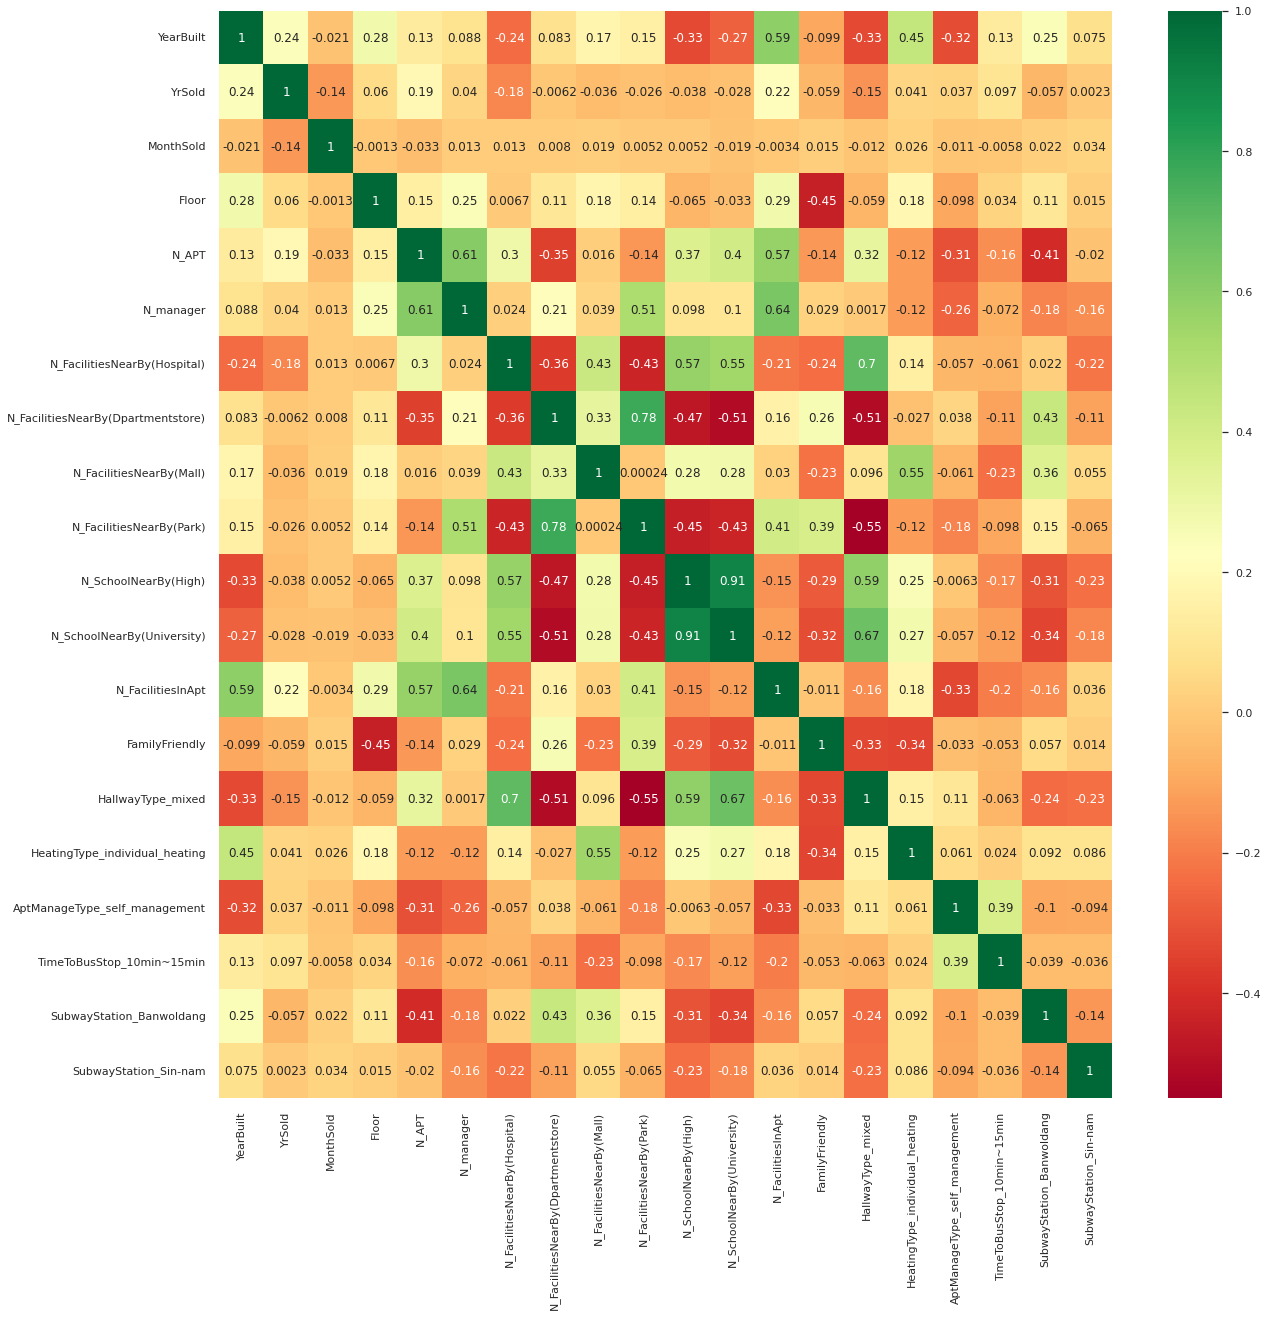

In [ ]:
#Cek korelasi antar fitur
data = X_new
sns.set(font_scale=1)
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")


In [ ]:
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
temp = 99999999
K = 0
for i in range (2, 22):
  cv = KFold(n_splits=i, random_state=1, shuffle=True) 
  #build multiple linear regression model
  model = LinearRegression()
  #use LOOCV to evaluate model
  scores = cross_val_score(model, X_new, y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
  #view RMSE
  RMSE = sqrt(mean(absolute(scores)))
  if RMSE < temp:
    temp = RMSE
    K = i

print(temp)
print(K)

35.10999952600808
8


In [ ]:
kf = KFold(n_splits=8, random_state=1, shuffle=True)
for train_index, test_index in kf.split(X):
  x_train, x_test, y_train, y_test = X_new.iloc[train_index], X_new.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
#Prediksi saleprice per square ft menggunakan Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn import metrics

linear = LinearRegression()
linear.fit(x_train, y_train)
y_predict = linear.predict(x_test)

# Nilai R-squared
print("R-squared:", metrics.r2_score(y_test, y_predict))
# Nilai MAE
print("MAE:", metrics.mean_absolute_error(y_test, y_predict))
# Nilai MSE
print("MSE:", metrics.mean_squared_error(y_test, y_predict))

R-squared: 0.8373076700254203
MAE: 26.51511966221499
MSE: 1218.146888726243


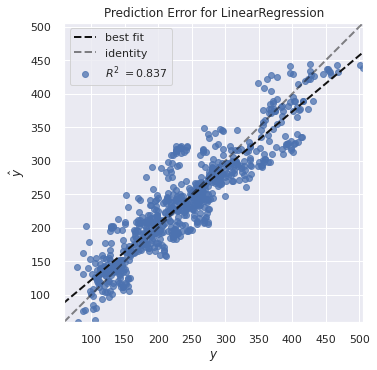

In [ ]:
from yellowbrick.regressor import PredictionError
visualizer =PredictionError(linear)
visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data 
g = visualizer.poof()             # Draw/show/poof the data

In [ ]:
#Prediction and actual data comparison
d = {'Prediction':y_predict,'Actual':y_test}
df = pd.DataFrame(d)
df

,Prediction,Actual
14,78.194861,102.595604
15,115.910275,144.285714
20,80.265770,107.191549
31,59.710589,79.901193
42,112.171752,147.169584
...,...,...
5863,309.305422,369.762238
5865,225.007648,199.425352
5871,233.566302,262.644518
5874,442.928019,467.211180


## Lakukan clustering pada data apartemen dan jelaskan karakteristik dari masing-masing cluster!

In [ ]:
cluster_data = daegu_df[['SalePrice', 'Size(sqf)','Floor']]

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

For n_clusters = 2 The average silhouette_coefficient is : 0.5798154137838014
For n_clusters = 3 The average silhouette_coefficient is : 0.5567326077850978
For n_clusters = 4 The average silhouette_coefficient is : 0.5539545780483202
For n_clusters = 5 The average silhouette_coefficient is : 0.5614843886282063
For n_clusters = 6 The average silhouette_coefficient is : 0.5517454887294481


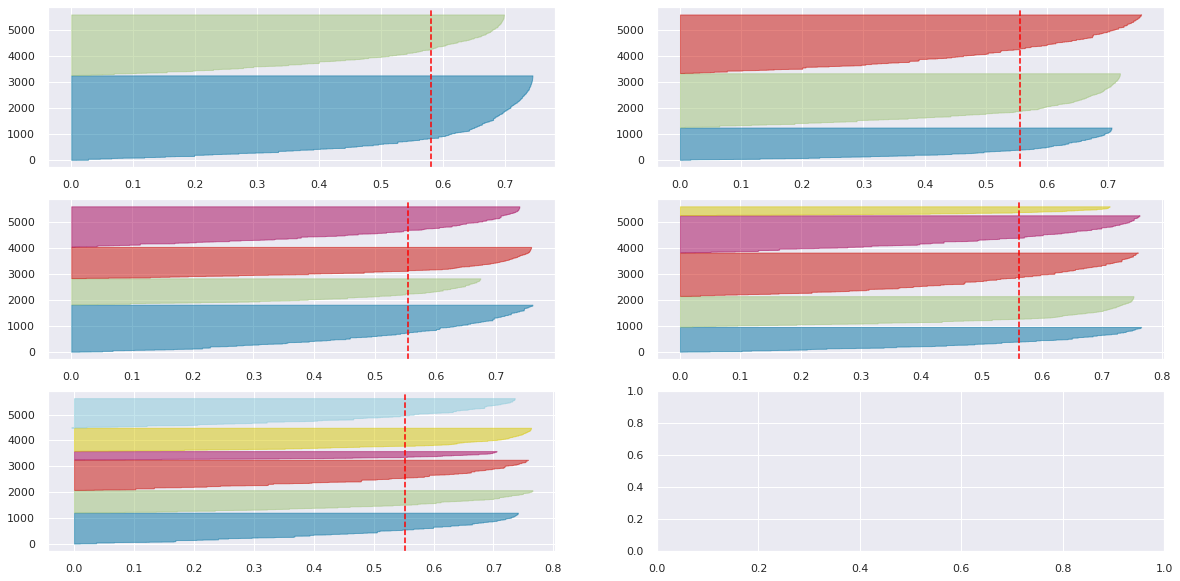

In [ ]:
#Silhouette score to determine best k value
fig, ax = plt.subplots(3, 2, figsize=(20,10))
for k in [2, 3, 4, 5, 6]:
    # Create KMeans instance for different number of clusters
    clusterer = KMeans(n_clusters = k)

    # Draw silhouette diagram
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(clusterer, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(cluster_data)

    # Compute silhoutte score
    # This gives a perspective into the density and separation of the formed clusters
    cluster_labels = clusterer.fit_predict(cluster_data)
    silhouette_avg = silhouette_score(cluster_data, cluster_labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_coefficient is :",
        silhouette_avg,
    )

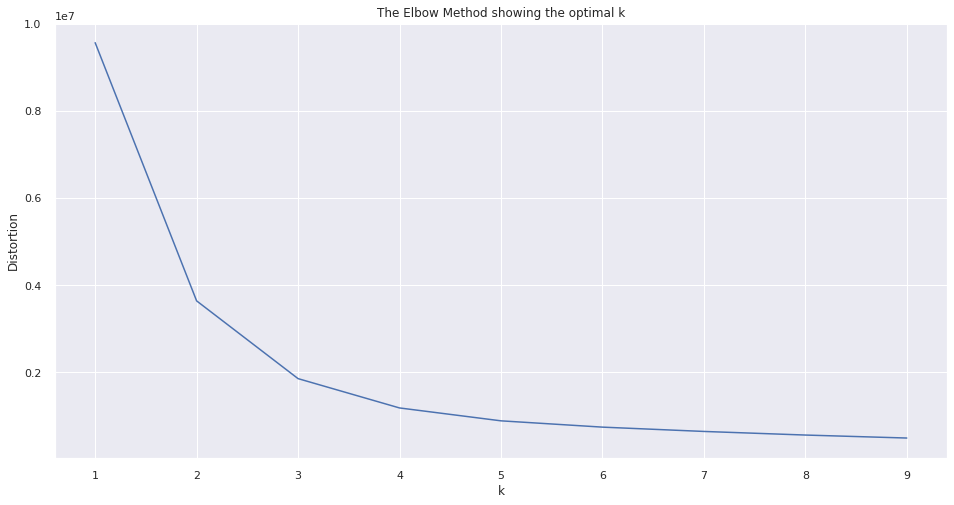

In [ ]:
#Elbow method to determine best k value
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2)
cluster_assignment = kmeans.fit_predict(cluster_data)
cluster_data['Clusters'] = cluster_assignment 
cluster_data

<ipython-input-165-a8189d6a0a7e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['Clusters'] = cluster_assignment


,SalePrice,Size(sqf),Floor,Clusters
0,141592,814,3,0
1,51327,587,8,0
2,48672,587,6,0
3,380530,2056,8,1
4,221238,1761,3,0
...,...,...,...,...
5886,511504,1643,19,1
5887,298230,903,13,1
5888,357522,868,20,1
5889,312389,1327,1,1


Text(0.5, 0, 'Floor')

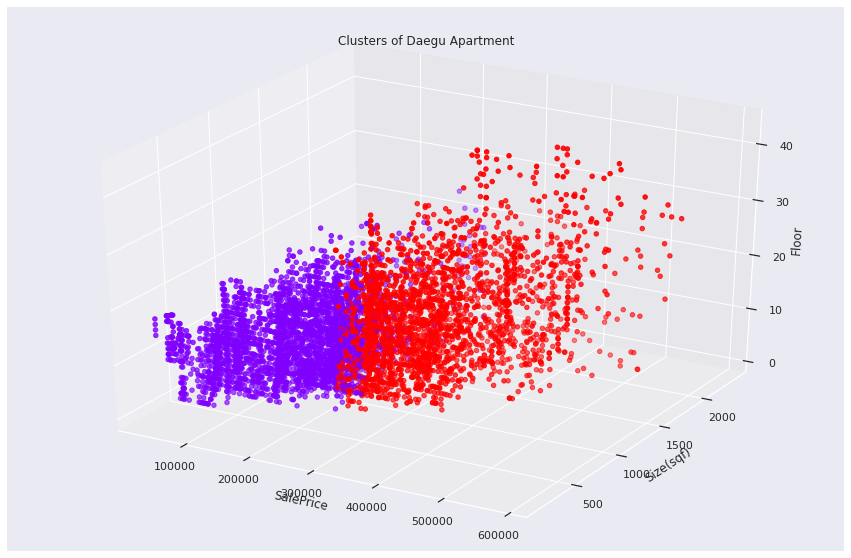

In [ ]:
# Create figure
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection ="3d")

# Prepare data
x = cluster_data['SalePrice']
y = cluster_data['Size(sqf)']
z = cluster_data['Floor']
cluster = cluster_data['Clusters']
 
# Create plot
ax.scatter(x, y, z, c = cluster, cmap = "rainbow")
plt.title("Clusters of Daegu Apartment")
ax.set_xlabel('SalePrice')
ax.set_ylabel('Size(sqf)')
ax.set_zlabel('Floor')

# Show plot

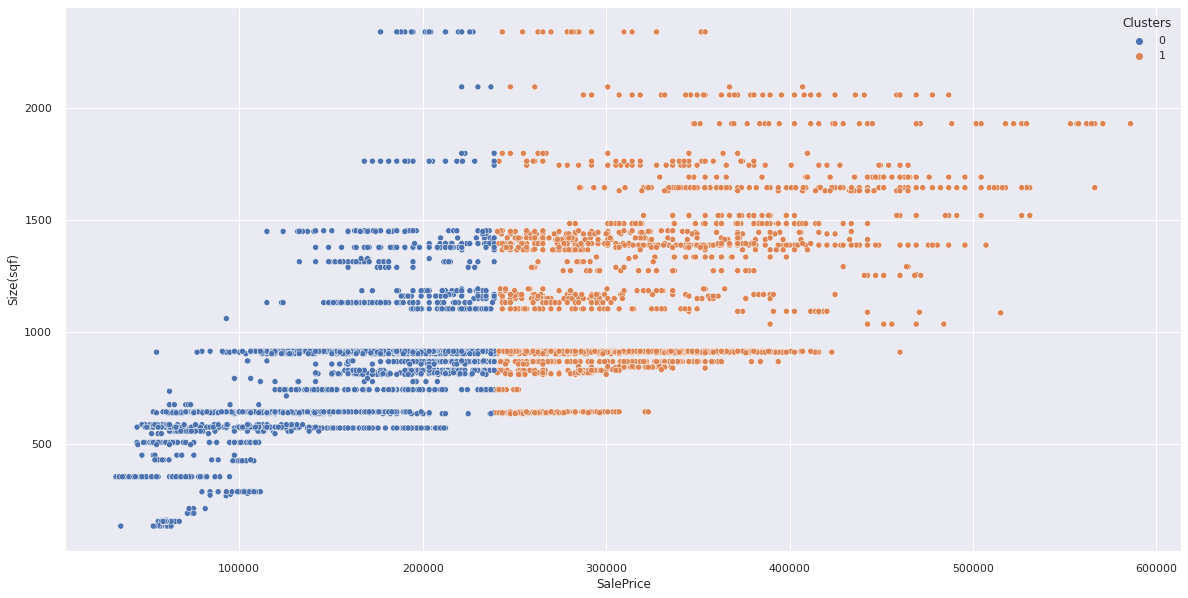

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = 'SalePrice',y = 'Size(sqf)', data = cluster_data, hue = 'Clusters',palette='deep')
plt.show()

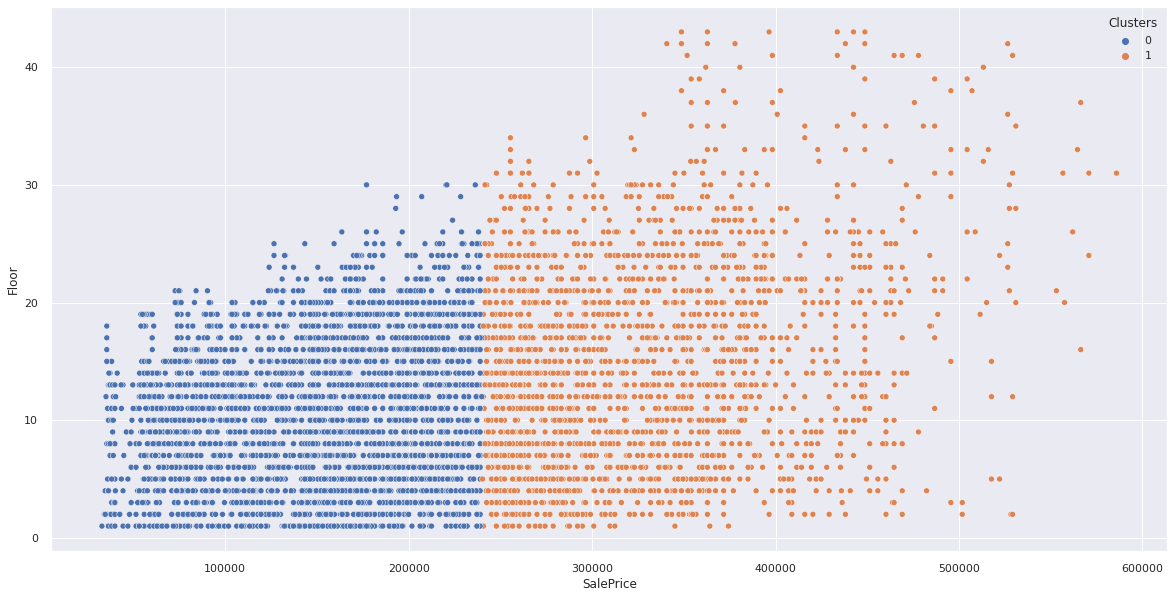

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x = 'SalePrice',y = 'Floor', data = cluster_data, hue = 'Clusters',palette='deep')
plt.show()

In [ ]:
#Interpretasi cluster

In [ ]:
# split cluster 0 and cluster 1
mask0 = cluster_data['Clusters'].values == 0
mask1 = cluster_data['Clusters'].values == 1
 
cluster_0 = cluster_data[mask0]
cluster_1 = cluster_data[mask1]
print(cluster_0)
print(cluster_1)

      SalePrice  Size(sqf)  Floor  Clusters
0        141592        814      3         0
1         51327        587      8         0
2         48672        587      6         0
4        221238       1761      3         0
5         35840        355      5         0
...         ...        ...    ...       ...
5865      70796        355      6         0
5866      72566        213     15         0
5869     183185        644      7         0
5871     237168        903      1         0
5873     201769        779      1         0

[3245 rows x 4 columns]
      SalePrice  Size(sqf)  Floor  Clusters
3        380530       2056      8         1
26       448672       1643     39         1
27       371681       1387     38         1
33       292035       2056      2         1
51       340707       1387     42         1
...         ...        ...    ...       ...
5886     511504       1643     19         1
5887     298230        903     13         1
5888     357522        868     20         1
5889   

In [ ]:
cluster_0.describe()

,SalePrice,Size(sqf),Floor,Clusters
count,3245.000000,3245.000000,3245.000000,3245.0
mean,151491.786749,808.711864,10.279199,0.0
std,54838.562371,307.874810,6.072239,0.0
min,32743.000000,135.000000,1.000000,0.0
25%,106194.000000,644.000000,5.000000,0.0
50%,158584.000000,829.000000,10.000000,0.0
75%,197601.000000,914.000000,15.000000,0.0
max,239823.000000,2337.000000,30.000000,0.0


In [ ]:
cluster_1.describe()

,SalePrice,Size(sqf),Floor,Clusters
count,2330.000000,2330.000000,2330.000000,2330.0
mean,328840.231330,1194.042489,14.724893,1.0
std,67778.570181,366.269933,8.736559,0.0
min,240265.000000,636.000000,1.000000,1.0
25%,269911.000000,910.000000,8.000000,1.0
50%,317699.000000,1103.000000,14.000000,1.0
75%,371681.000000,1448.000000,21.000000,1.0
max,585840.000000,2337.000000,43.000000,1.0


In [ ]:
#Mode of column floor in cluster 0
cluster_0['Floor'].mode()

0    11
dtype: int64

In [ ]:
#Mode of column floor in cluster 1
cluster_1['Floor'].mode()

0    7
dtype: int64

Karakteristik masing-masing cluster apartemen :
1. Cluster 0
*   Rata-rata SalePrice adalah 151491.786749 
*   Rata-rata Size(sqf) adalah 808.711864
*   Rata-rata floor adalah 10 sedangkan unit paling banyak berada pada lantai 11
*   SalePrice tertinggi adalah sebesar 239823 sedangkan SalePrice terendah sebesar 32743
*   Size(sqf) terbesar adalah 2337 sedangkan terkecil adalah 135

2. Cluster 1
*   Rata-rata SalePrice adalah 328840.231330
*   Rata-rata Size(sqf) adalah 1194.042489
*   Rata-rata floor adalah 14 sedangkan unit paling banyak berada pada lantai 7
*   SalePrice tertinggi adalah sebesar 58584 sedangkan SalePrice terendah sebesar 240265
*   Size(sqf) terbesar adalah 2337 sedangkan terkecil adalah 636

Kesimpulan:
Apartemen pada cluster 0 cenderung memiliki SalePrice dan Size(sqf) lebih rendah dibanding dengan cluster 1. Untuk lantai, tidak ada perbedaan yang signifikan antara cluster 0 dan cluster 1, keduanya tersebar dari lantai bawah sampai lantai atas. Namun, apartemen pada cluster 0 paling tinggi ada di lantai 30, sedangkan apartemen pada cluster 1 ada yang berada di lantai 43.





